# Download Modules

In [ ]:
!pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu118
!pip install transformers sentencepiece datasets evaluate optuna rouge_score sacrebleu trl==0.8.0

Looking in indexes: https://download.pytorch.org/whl/nightly/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 99.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 110.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 5.7 

In [67]:
from datasets import load_dataset
from google.colab import drive
from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.optim import AdamW
from torch.nn import functional as F
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook

sns.set()

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [65]:
# Use 'google/mt5-small' for non-pro cloab users
model_repo = 'google/mt5-small'
model_path = '/content/gdrive/MyDrive/mt5_translation.pt'
max_seq_len = 20

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_repo)

In [68]:
# Model description: https://huggingface.co/google/mt5-small
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
model = model.cuda()

In [69]:
token_ids = tokenizer.encode(
    '<id> This will be translated to Indonesian! (hopefully)',
    return_tensors='pt').cuda()
print(token_ids)

model_out = model.generate(token_ids)
print(model_out)

output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0]))
print(output_text)

tensor([[250101,   1494,    898,    390,  37194,    285,    288,   3664,    272,
            309,    274, 116024,  11994,    271,      1]], device='cuda:0')
tensor([[     0, 250099,      1]], device='cuda:0')
<pad> <extra_id_0></s>


# Test Tokenizer

In [ ]:
example_input_str = '<id> This is just a test nbuig.'
input_ids = tokenizer.encode(example_input_str, return_tensors='pt')
print('Input IDs:', input_ids)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print('Tokens:', tokens)

In [ ]:
sorted(tokenizer.vocab.items(), key=lambda x: x[1])

In [ ]:
# Source: https://huggingface.co/datasets/alt
dataset = load_dataset('alt')

In [ ]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [ ]:
train_dataset[0]

{'SNT.URLID': '80188',
 'SNT.URLID.SNTID': '1',
 'url': 'http://en.wikinews.org/wiki/2007_Rugby_World_Cup:_Italy_31_-_5_Portugal',
 'translation': {'bg': 'ফ্রান্সের প্যারিসের পার্ক দি প্রিন্সেস-এ হওয়া ২০০৭-এর রাগবি বিশ্বকাপের পুল সি-তে ইটালি পর্তুগালকে ৩১-৫ গোলে হারিয়েছে।',
  'en': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.',
  'en_tok': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes , Paris , France .',
  'fil': 'Natalo ng Italya ang Portugal sa puntos na 31-5 sa Grupong C noong 2007 sa Pandaigdigang laro ng Ragbi sa Parc des Princes, Paris, France.',
  'hi': '2007 में फ़्रांस, पेरिस के पार्क डेस प्रिंसेस में हुए रग्बी विश्व कप के पूल C में इटली ने पुर्तगाल को 31-5 से हराया।',
  'id': 'Italia berhasil mengalahkan Portugal 31-5 di grup C dalam Piala Dunia Rugby 2007 di Parc des Princes, Paris, Perancis.',
  'ja': 'フランスのパリ、パルク・デ・プランスで行われた2007年ラグビーワールドカップのプールCで、イタリアは31対5でポルトガルを

In [ ]:
LANG_TOKEN_MAPPING = {
    'en': '<en>',
    'id': '<id>'
}

In [ ]:
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

Embedding(250102, 512)

In [ ]:
token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt', padding='max_length',
    truncation=True, max_length=max_seq_len)
print(token_ids)

tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
print(tokens)

tensor([[250101,   1494,    339,   1627,    259,    262,   2978,    259,    272,
           1982,   1315,    260,      1,      0,      0,      0,      0,      0,
              0,      0]])
['<id>', '▁This', '▁is', '▁just', '▁', 'a', '▁test', '▁', 'n', 'bu', 'ig', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [ ]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]

def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return token_ids[0]

def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
  input_lang, target_lang = 'en', 'id'

  # Get the translations for the batch
  input_text = translations[input_lang]
  target_text = translations[target_lang]

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_input_str(
      input_text, target_lang, tokenizer, seq_len, lang_token_map)

  target_token_ids = encode_target_str(
      target_text, tokenizer, seq_len, lang_token_map)

  return input_token_ids, target_token_ids

def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch['translation']:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len)

    if formatted_data is None:
      continue

    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))

  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.shuffle()
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, lang_token_map, tokenizer)

In [ ]:
# Testing `data_transform`
in_ids, out_ids = format_translation_data(
    train_dataset[0]['translation'], LANG_TOKEN_MAPPING, tokenizer)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

# Testing data generator
data_gen = get_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

<id> ▁Italy ▁have ▁de feat ed ▁Portugal ▁3 1-5 ▁in ▁Pool ▁C ▁of ▁the ▁2007 ▁ Rugby ▁World ▁Cup ▁at ▁Parc ▁des ▁Princes , ▁Paris , ▁France . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
▁Italia ▁ber hasil ▁menga lahkan ▁Portugal ▁3 1-5 ▁di ▁grup ▁C ▁dalam ▁Pia la ▁ Dunia ▁ Rugby ▁2007 ▁di ▁Parc ▁des ▁Princes , ▁Paris , ▁Pe rancis . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

Hyperparameters

In [ ]:
# Constants
n_epochs = 4
batch_size = 16
print_freq = 50
checkpoint_freq = 1000
lr = 5e-4
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

Testing MT5-small to compare with supervised-finetuned model.

In [70]:
import evaluate
bleu_metric = evaluate.load('sacrebleu')
rouge_metric = evaluate.load('rouge')
meteor_metric = evaluate.load('meteor')

# Get test data
model.eval()
test_generator = get_data_generator(test_dataset, LANG_TOKEN_MAPPING, tokenizer, batch_size)
all_preds = []
all_refs = []

# Collect predictions and references
for input_batch, label_batch in test_generator:
    with torch.no_grad():
        model_out = model.generate(input_ids=input_batch)
    preds = tokenizer.batch_decode(model_out, skip_special_tokens=True)
    refs = tokenizer.batch_decode(label_batch, skip_special_tokens=True)
    all_preds.extend(preds)
    all_refs.extend(refs)

# Store per-example scores
bleu_scores = []
rouge_scores = []
meteor_scores = []

for pred, ref in zip(all_preds, all_refs):
    # BLEU expects a list of references (even if it's just one)
    bleu = bleu_metric.compute(predictions=[pred], references=[[ref]])['score']
    rouge = rouge_metric.compute(predictions=[pred], references=[ref], rouge_types=["rougeL"], use_stemmer=True)['rougeL'] * 100
    meteor = meteor_metric.compute(predictions=[pred], references=[ref])['meteor'] * 100

    bleu_scores.append(bleu)
    rouge_scores.append(rouge)
    meteor_scores.append(meteor)

# Compute mean and standard deviation
print(f"BLEU Score: Mean = {np.mean(bleu_scores):.2f}, Std = {np.std(bleu_scores):.2f}")
print(f"ROUGE-L Score: Mean = {np.mean(rouge_scores):.2f}, Std = {np.std(rouge_scores):.2f}")
print(f"METEOR Score: Mean = {np.mean(meteor_scores):.2f}, Std = {np.std(meteor_scores):.2f}")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


BLEU Score: Mean = 0.13, Std = 0.69
ROUGE-L Score: Mean = 0.06, Std = 0.92
METEOR Score: Mean = 0.16, Std = 0.88


In [ ]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

In [ ]:
losses = []

In [ ]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [ ]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(train_dataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)

  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    # Calculate loss and update weights
    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))

    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model, test_dataset)
      print('Saving model with test loss of {:.3f}'.format(test_loss))
      torch.save(model.state_dict(), model_path)

torch.save(model.state_dict(), model_path)

<ipython-input-58-9682a3c86c07>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 1 | Step: 50 | Avg. loss: 2.877 | lr: 0.0004822505023442733
Epoch: 1 | Step: 100 | Avg. loss: 2.655 | lr: 0.0004766688993078812
Epoch: 1 | Step: 150 | Avg. loss: 2.493 | lr: 0.00047108729627148914
Epoch: 1 | Step: 200 | Avg. loss: 2.363 | lr: 0.0004655056932350971
Epoch: 1 | Step: 250 | Avg. loss: 2.285 | lr: 0.00045992409019870507
Epoch: 1 | Step: 300 | Avg. loss: 2.245 | lr: 0.00045434248716231303
Epoch: 1 | Step: 350 | Avg. loss: 2.115 | lr: 0.000448760884125921
Epoch: 1 | Step: 400 | Avg. loss: 2.105 | lr: 0.0004431792810895289
Epoch: 1 | Step: 450 | Avg. loss: 2.085 | lr: 0.0004375976780531369
Epoch: 1 | Step: 500 | Avg. loss: 2.025 | lr: 0.00043201607501674484
Epoch: 1 | Step: 550 | Avg. loss: 1.998 | lr: 0.0004264344719803528
Epoch: 1 | Step: 600 | Avg. loss: 1.931 | lr: 0.00042085286894396067
Epoch: 1 | Step: 650 | Avg. loss: 1.907 | lr: 0.00041527126590756863
Epoch: 1 | Step: 700 | Avg. loss: 1.888 | lr: 0.0004096896628711766
Epoch: 1 | Step: 750 | Avg. loss: 1.818 | lr

  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 2 | Step: 50 | Avg. loss: 1.469 | lr: 0.0003559946416610851
Epoch: 2 | Step: 100 | Avg. loss: 1.437 | lr: 0.000350413038624693
Epoch: 2 | Step: 150 | Avg. loss: 1.440 | lr: 0.000344831435588301
Epoch: 2 | Step: 200 | Avg. loss: 1.451 | lr: 0.0003392498325519089
Epoch: 2 | Step: 250 | Avg. loss: 1.412 | lr: 0.00033366822951551685
Epoch: 2 | Step: 300 | Avg. loss: 1.424 | lr: 0.0003280866264791248
Epoch: 2 | Step: 350 | Avg. loss: 1.407 | lr: 0.00032250502344273273
Epoch: 2 | Step: 400 | Avg. loss: 1.451 | lr: 0.0003169234204063407
Epoch: 2 | Step: 450 | Avg. loss: 1.418 | lr: 0.00031134181736994866
Epoch: 2 | Step: 500 | Avg. loss: 1.440 | lr: 0.0003057602143335566
Epoch: 2 | Step: 550 | Avg. loss: 1.380 | lr: 0.00030017861129716454
Epoch: 2 | Step: 600 | Avg. loss: 1.410 | lr: 0.0002945970082607725
Epoch: 2 | Step: 650 | Avg. loss: 1.428 | lr: 0.00028901540522438047
Epoch: 2 | Step: 700 | Avg. loss: 1.466 | lr: 0.00028343380218798843
Epoch: 2 | Step: 750 | Avg. loss: 1.457 | lr:

  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 3 | Step: 50 | Avg. loss: 1.129 | lr: 0.00022973878097789686
Epoch: 3 | Step: 100 | Avg. loss: 1.138 | lr: 0.00022415717794150482
Epoch: 3 | Step: 150 | Avg. loss: 1.139 | lr: 0.00021857557490511276
Epoch: 3 | Step: 200 | Avg. loss: 1.115 | lr: 0.0002129939718687207
Epoch: 3 | Step: 250 | Avg. loss: 1.129 | lr: 0.00020741236883232864
Epoch: 3 | Step: 300 | Avg. loss: 1.147 | lr: 0.0002018307657959366
Epoch: 3 | Step: 350 | Avg. loss: 1.128 | lr: 0.00019624916275954454
Epoch: 3 | Step: 400 | Avg. loss: 1.136 | lr: 0.0001906675597231525
Epoch: 3 | Step: 450 | Avg. loss: 1.126 | lr: 0.00018508595668676045
Epoch: 3 | Step: 500 | Avg. loss: 1.147 | lr: 0.00017950435365036838
Epoch: 3 | Step: 550 | Avg. loss: 1.134 | lr: 0.00017392275061397632
Epoch: 3 | Step: 600 | Avg. loss: 1.109 | lr: 0.0001683411475775843
Epoch: 3 | Step: 650 | Avg. loss: 1.120 | lr: 0.00016275954454119223
Epoch: 3 | Step: 700 | Avg. loss: 1.110 | lr: 0.0001571779415048002
Epoch: 3 | Step: 750 | Avg. loss: 1.131 

  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 4 | Step: 50 | Avg. loss: 0.867 | lr: 0.00010348292029470864
Epoch: 4 | Step: 100 | Avg. loss: 0.870 | lr: 9.790131725831659e-05
Epoch: 4 | Step: 150 | Avg. loss: 0.884 | lr: 9.231971422192453e-05
Epoch: 4 | Step: 200 | Avg. loss: 0.917 | lr: 8.673811118553248e-05
Epoch: 4 | Step: 250 | Avg. loss: 0.900 | lr: 8.115650814914043e-05
Epoch: 4 | Step: 300 | Avg. loss: 0.906 | lr: 7.557490511274837e-05
Epoch: 4 | Step: 350 | Avg. loss: 0.948 | lr: 6.999330207635634e-05
Epoch: 4 | Step: 400 | Avg. loss: 0.906 | lr: 6.441169903996428e-05
Epoch: 4 | Step: 450 | Avg. loss: 0.918 | lr: 5.883009600357222e-05
Epoch: 4 | Step: 500 | Avg. loss: 0.917 | lr: 5.3248492967180175e-05
Epoch: 4 | Step: 550 | Avg. loss: 0.866 | lr: 4.766688993078813e-05
Epoch: 4 | Step: 600 | Avg. loss: 0.892 | lr: 4.208528689439607e-05
Epoch: 4 | Step: 650 | Avg. loss: 0.898 | lr: 3.650368385800402e-05
Epoch: 4 | Step: 700 | Avg. loss: 0.901 | lr: 3.092208082161197e-05
Epoch: 4 | Step: 750 | Avg. loss: 0.889 | lr: 2

In [64]:
torch.save(model.state_dict(), model_path)

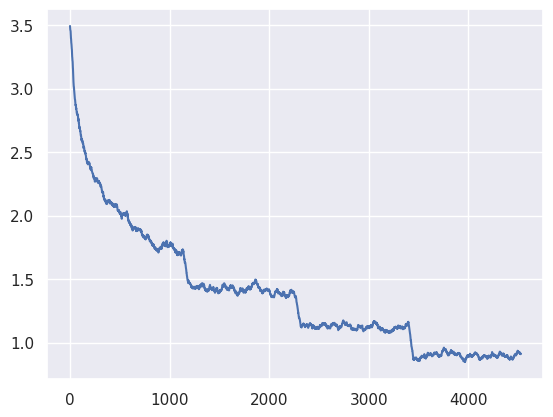

In [60]:
# Graph the loss

window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

In [61]:
test_sentence = test_dataset[0]['translation']['en']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'id',
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza.
Truncated input text: <id> It has been confirmed that eight thoroughbred race horses at Randwick Racecourse</s>


In [62]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

Hal ini telah dikonfirmasi bahwa 8 kuda lomba kuda di Randwick Race
Hal ini telah dikonfirmasi bahwa 8 kuda bala di Racecourse Randwick Race
Hal ini telah dikonfirmasi bahwa delapan kuda bala di Racecourse Randwick


In [66]:
# Get test data
model.eval()
test_generator = get_data_generator(test_dataset, LANG_TOKEN_MAPPING, tokenizer, batch_size)
all_preds = []
all_refs = []

# Collect predictions and references
for input_batch, label_batch in test_generator:
    with torch.no_grad():
        model_out = model.generate(input_ids=input_batch)
    preds = tokenizer.batch_decode(model_out, skip_special_tokens=True)
    refs = tokenizer.batch_decode(label_batch, skip_special_tokens=True)
    all_preds.extend(preds)
    all_refs.extend(refs)

# Store per-example scores
bleu_scores = []
rouge_scores = []
meteor_scores = []

for pred, ref in zip(all_preds, all_refs):
    # BLEU expects a list of references (even if it's just one)
    bleu = bleu_metric.compute(predictions=[pred], references=[[ref]])['score']
    rouge = rouge_metric.compute(predictions=[pred], references=[ref], rouge_types=["rougeL"], use_stemmer=True)['rougeL'] * 100
    meteor = meteor_metric.compute(predictions=[pred], references=[ref])['meteor'] * 100

    bleu_scores.append(bleu)
    rouge_scores.append(rouge)
    meteor_scores.append(meteor)

# Compute mean and standard deviation
print(f"BLEU Score: Mean = {np.mean(bleu_scores):.2f}, Std = {np.std(bleu_scores):.2f}")
print(f"ROUGE-L Score: Mean = {np.mean(rouge_scores):.2f}, Std = {np.std(rouge_scores):.2f}")
print(f"METEOR Score: Mean = {np.mean(meteor_scores):.2f}, Std = {np.std(meteor_scores):.2f}")


BLEU Score: Mean = 24.63, Std = 18.79
ROUGE-L Score: Mean = 50.98, Std = 18.03
METEOR Score: Mean = 48.30, Std = 19.77
